<a href="https://colab.research.google.com/github/cgray1117/NLPTransformersProject/blob/main/Copy_of_T5new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## pip Install
!pip install SentencePiece
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 25.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 37.4 MB/s 
     |████████████████████████████████| 6.6 MB 51.3 MB/s 
     |████████████████████████████████| 120 kB 34.5 MB/s 


In [2]:
## Import libraries
import sentencepiece
import numpy as np
import regex as re
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras

import tokenizers
from transformers import T5Tokenizer, TFT5Model
from collections import Counter

In [3]:
MODEL_NAME = 't5-small'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'
EPOCHS = 5
if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

## Data NLP

In [5]:
df = pd.read_csv('project_data.csv')

# Identify null and remove
df["Label"].isnull().sum()
df['Label'].replace('', np.nan, inplace=True)
df.dropna(subset=['Label'], inplace=True)

In [6]:
# Drop extra columns
df = df.drop('Username', axis=1)
df = df.drop('UserLocation', axis=1)
df.head()

,Datetime,Text,Label
0,2022-08-07 21:15:43+00:00,Accident in #Manhattan on The FDR Drive SB at ...,1.0
1,2022-07-29 10:25:44+00:00,Closed due to Police Activity in #NewYork on W...,2.0
2,2022-07-29 10:25:44+00:00,Closed due to Police Activity in #NewYork on A...,2.0
3,2022-07-29 10:10:43+00:00,Closed due to Police Activity in #NewYork on A...,2.0
4,2022-07-29 09:50:43+00:00,Closed due to Police Activity in #NewYork on A...,2.0


In [7]:
tknzr = TweetTokenizer()

# Tokenize each tweet
df['tokenized'] = df['Text'].map(lambda t: tknzr.tokenize(t))

# lowecase, strip and ensure we only include words
df['tokenized'] = df['tokenized'].map(
    lambda t: [word.lower().strip() for word in t if word.isalpha()])

# Importing stopwords
nltk.download("stopwords")

stopwords_en = stopwords.words('english')

# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# lemmarize and remove stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')

df['tokenized'] = df['tokenized'].map(
    lambda t: [wordnet_lemmatizer.lemmatize(word) for word in t 
               if word not in stopwords_en])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
df['tokenized'][:10]

0    [accident, fdr, drive, sb, st, stopped, traffi...
1    [closed, due, police, activity, west, street, ...
2    [closed, due, police, activity, avenue, americ...
3    [closed, due, police, activity, avenue, americ...
4    [closed, due, police, activity, avenue, americ...
5    [closed, due, police, activity, avenue, americ...
6    [closed, due, police, activity, west, street, ...
7    [overturned, vehicle, two, lane, blocked, onth...
8    [left, lane, blocked, onthefdr, fdr, drive, sb...
9    [overturned, vehicle, two, lane, blocked, onth...
Name: tokenized, dtype: object

In [9]:
token_tweets = []
for lst in df['tokenized']:
  txt = " ".join(lst)
  token_tweets.append(txt)

X_data = np.array(token_tweets)
y_data = df[["Label"]].to_numpy().reshape(-1)

## EDA

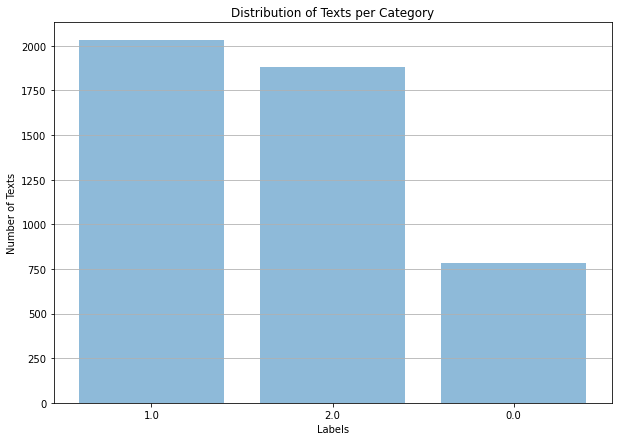

Counter({1.0: 2030, 2.0: 1881, 0.0: 784})


In [10]:
categories = df[['Label']].values.reshape(-1)

counter_categories = Counter(categories)
counter_categories

category_names = counter_categories.keys()
category_values = counter_categories.values()
y_pos = np.arange(len(category_names))

# Create distribution of labels figure
plt.figure(1, figsize=(10, 7))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of Texts')
plt.xlabel('Labels')
plt.title('Distribution of Texts per Category')
plt.gca().yaxis.grid(True)
plt.show()
print(counter_categories)

In [11]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)
n_categories = len(df['Label'].unique())
print('Number of categories: %d' % n_categories)

Texts in dataset: 4695
Number of categories: 3


## Decode, and Create Roberta

In [12]:
def t5_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32')

    for k, text in enumerate(texts):
        tok_text = tokenizer.tokenize(text)
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        attention_mask[k,:input_length] = 1

    return {'input_word_ids': input_ids,'input_mask': attention_mask,
            'input_type_ids': token_type_ids}

In [13]:
# Train test validation split
X_train, X_rem, y_train, y_rem = train_test_split(X_data, y_data, train_size=0.7, random_state=444)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [14]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

X_train = t5_encode(X_train, tokenizer)
X_test = t5_encode(X_test, tokenizer)
X_valid = t5_encode(X_valid, tokenizer)

y_valid = np.asarray(y_valid, dtype='int32').reshape(-1)
y_train = np.asarray(y_train, dtype='int32').reshape(-1)
y_test = np.asarray(y_test, dtype='int32').reshape(-1) 

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


## Build Model

In [15]:
def build_model(n_categories):
      input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
      input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
      input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

      # Import RoBERTa model from HuggingFace
      T5_model = TFT5Model.from_pretrained(MODEL_NAME)
      x = T5_model(input_word_ids, attention_mask=input_mask, decoder_input_ids=input_type_ids)

      # Huggingface transformers have multiple outputs, embeddings are the first one,
      # so let's slice out the first position
      x = x[0]

      x = tf.keras.layers.Dropout(0.1)(x)
      x = tf.keras.layers.Flatten()(x)
      x = tf.keras.layers.Dense(256, activation='relu')(x)
      x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

      model = tf.keras.Model(inputs=[input_word_ids, input_mask,input_type_ids], outputs=x)
      #input_ids = input_word_ids, attention_mask = input_mask, decoder_input_ids = input_type_ids
      model.compile(
          optimizer=tf.keras.optimizers.Adam(lr=1e-5),
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

      return model
      

In [16]:
model = build_model(n_categories)
model.summary()

All model checkpoint layers were used when initializing TFT5Model.

All the layers of TFT5Model were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5Model for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tft5_model (TFT5Model)         TFSeq2SeqModelOutpu  60506624    ['input_word_ids[0][0]',         
                                t(last_hidden_state               'input_mask[0][0]',         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Train & Evaluate

Epoch 1/5
206/206 [==============================] - 127s 542ms/step - loss: 0.4235 - accuracy: 0.8214 - val_loss: 0.1391 - val_accuracy: 0.9389
Epoch 2/5
206/206 [==============================] - 114s 553ms/step - loss: 0.1652 - accuracy: 0.9358 - val_loss: 0.1141 - val_accuracy: 0.9531
Epoch 3/5
206/206 [==============================] - 114s 552ms/step - loss: 0.1360 - accuracy: 0.9498 - val_loss: 0.1081 - val_accuracy: 0.9574
Epoch 4/5
206/206 [==============================] - 110s 533ms/step - loss: 0.1216 - accuracy: 0.9553 - val_loss: 0.1321 - val_accuracy: 0.9489
Epoch 5/5
206/206 [==============================] - 114s 552ms/step - loss: 0.1136 - accuracy: 0.9562 - val_loss: 0.0924 - val_accuracy: 0.9588
[1.3453350067138672, 1.235896348953247, 1.2371011972427368, 1.2582730054855347, 1.239883303642273, 1.2196992635726929, 1.2209783792495728, 1.1509740352630615, 1.137430191040039, 1.128139615058899, 1.1100904941558838, 1.090044617652893, 1.084513783454895, 1.0775506496429443, 

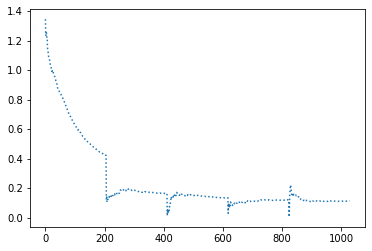

In [17]:
# the code in this block was adpated from https://stackoverflow.com/questions/48118111/get-loss-values-for-each-training-instance-keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()
model.fit(X_train, y_train, batch_size=16, epochs=EPOCHS, verbose=1, validation_data=(X_valid,y_valid), callbacks=[history])
print(history.losses)


plt.plot(history.losses, linestyle = 'dotted')
plt.show()

# history = model.fit(X_train,y_train,epochs=EPOCHS,batch_size=16,verbose=1,validation_data=(X_test, y_test))

## Visualizations

In [18]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

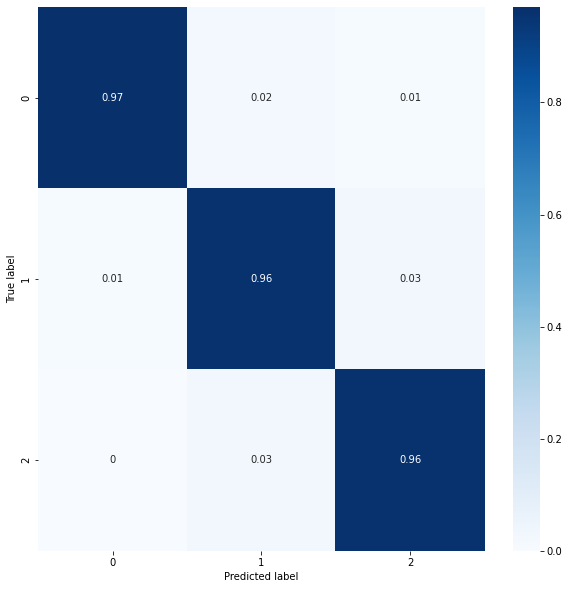

In [19]:
plot_confusion_matrix(X_test, y_test, model)

## Results

In [20]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(i) for i in model.predict(X_test)]

In [21]:
print("precision: " + str(precision_score(y_test, y_pred, average="micro")))
print("recall: " + str(recall_score(y_test, y_pred, average="micro")))
print("f1: " + str(f1_score(y_test, y_pred, average="micro")))
print("accuracy: " + str(model.evaluate(X_test, y_test)[1]*100))

precision: 0.9617021276595744
recall: 0.9617021276595744
f1: 0.9617021276595744
23/23 [==============================] - 10s 285ms/step - loss: 0.1031 - accuracy: 0.9617
accuracy: 96.17021083831787
